In [691]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
#import seaborn as sns
import os
import warnings
%matplotlib inline

In [692]:
# Read in data
raw_df = pd.read_csv('./data/master.csv')
raw_df.head()

,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI for year,gdp_for_year ($),gdp_per_capita ($),generation
0,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,NaN,"2,156,624,900",796,Generation X
1,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,NaN,"2,156,624,900",796,Silent
2,Albania,1987,female,15-24 years,14,289700,4.83,Albania1987,NaN,"2,156,624,900",796,Generation X
3,Albania,1987,male,75+ years,1,21800,4.59,Albania1987,NaN,"2,156,624,900",796,G.I. Generation
4,Albania,1987,male,25-34 years,9,274300,3.28,Albania1987,NaN,"2,156,624,900",796,Boomers


In [693]:
# Remove spaces from coloumn name
raw_df.rename(columns={' gdp_for_year ($) ':'gdp_for_year ($)'}, inplace=True)
raw_df.columns

Index(['country', 'year', 'sex', 'age', 'suicides_no', 'population',
       'suicides/100k pop', 'country-year', 'HDI for year', 'gdp_for_year ($)',
       'gdp_per_capita ($)', 'generation'],
      dtype='object')

In [694]:
# Drop na values in HDI
raw_df.loc[raw_df['HDI for year'].isna(), ['country', 'year']].drop_duplicates()

,country,year
0,Albania,1987
12,Albania,1988
24,Albania,1989
36,Albania,1992
48,Albania,1993
...,...,...
27688,Uzbekistan,2001
27700,Uzbekistan,2002
27712,Uzbekistan,2003
27724,Uzbekistan,2004


In [695]:
# Still missing a lot of HDI data
# Decided to drop column so as to not skew results due to missing information in some rows
raw_df.drop(["HDI for year"], axis=1)

# Also drop country-year since it is already given in the year column
raw_df.drop(columns=['country-year'], inplace=True)
raw_df.columns

Index(['country', 'year', 'sex', 'age', 'suicides_no', 'population',
       'suicides/100k pop', 'HDI for year', 'gdp_for_year ($)',
       'gdp_per_capita ($)', 'generation'],
      dtype='object')

In [696]:
# Create additional column for suicide risk and set the default value as low == 0
raw_df['suicide_risk'] = 0 

# Set the risk as high if suicides/100k pop is higher than the mean, high == 1
# Compare the value of suicides/100k to the mean of all suicides/100k.
# If the value is lower than the mean we'll say it is a low risk (0), else a high risk (1)

raw_df.loc[raw_df['suicides/100k pop'] > raw_df['suicides/100k pop'].mean(), 'suicide_risk'] = 1 
raw_df['suicide_risk'].value_counts()

0    19061
1     8759
Name: suicide_risk, dtype: int64

In [697]:
# Create a series containing number of data per year
year_dt = raw_df.year.value_counts()
year_dt.sort_index(inplace=True)
cum_pct = 100 * year_dt.cumsum() / year_dt.sum()
cum_pct

1985      2.070453
1986      4.140906
1987      6.470165
1988      8.583753
1989     10.826743
1990     13.587347
1991     16.347951
1992     19.151689
1993     21.955428
1994     24.888569
1995     28.253055
1996     31.574407
1997     34.895758
1998     38.303379
1999     41.883537
2000     45.593098
2001     49.388929
2002     53.098490
2003     56.808052
2004     60.431344
2005     64.054637
2006     67.721064
2007     71.430625
2008     75.097052
2009     78.936017
2010     82.731848
2011     86.441409
2012     89.935298
2013     93.386053
2014     96.750539
2015     99.424874
2016    100.000000
Name: year, dtype: float64

In [698]:
# Split data into 80/10/10

train_df = raw_df.loc[raw_df['year'] <= 2009]
val_df = raw_df.loc[(raw_df['year'] >= 2010) & (raw_df['year'] <=2012)]
test_df = raw_df.loc[raw_df['year'] >= 2013]

print('train_df.shape: ', train_df.shape)
print('val_df.shape: ', val_df.shape)
print('test_df.shape: ', test_df.shape)

train_df.shape:  (21960, 12)
val_df.shape:  (3060, 12)
test_df.shape:  (2800, 12)


In [699]:
input_cols = ['country', 'sex', 'age', 'gdp_per_capita ($)']
target_col = 'suicide_risk'

In [700]:
train_inputs = train_df.loc[:, input_cols]
train_target = train_df.loc[:, target_col]

val_inputs = val_df.loc[:, input_cols]
val_target = val_df.loc[:, target_col]

test_inputs = test_df.loc[:, input_cols]
test_target = test_df.loc[:, target_col]


In [701]:
numeric_cols = list(train_inputs.select_dtypes(include=np.number).columns)
categorical_cols = list(train_inputs.select_dtypes(include='object').columns)

print('numeric columns: ', numeric_cols)
print('categorical columns: ', categorical_cols)

numeric columns:  ['gdp_per_capita ($)']
categorical columns:  ['country', 'sex', 'age']


In [702]:
from sklearn.preprocessing import MinMaxScaler

# Fit the scaler to all the data
scaler = MinMaxScaler().fit(raw_df.loc[:, numeric_cols])

# Scale the train, validation and test sets 
train_inputs.loc[:, numeric_cols] = scaler.transform(train_inputs.loc[:, numeric_cols])
val_inputs.loc[:, numeric_cols] = scaler.transform(val_inputs.loc[:, numeric_cols])
test_inputs.loc[:, numeric_cols] = scaler.transform(test_inputs.loc[:, numeric_cols])



In [703]:
train_inputs[numeric_cols].describe()

,gdp_per_capita ($)
count,21960.000000
mean,0.111703
std,0.126815
min,0.000000
25%,0.020373
50%,0.057252
75%,0.178032
max,0.960056


In [704]:
# Check the number of unique values of each categorical column
raw_df[categorical_cols].nunique()

country    101
sex          2
age          6
dtype: int64

In [705]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(handle_unknown='ignore').fit(raw_df[categorical_cols])

In [706]:
encoded_cols = list(encoder.get_feature_names(categorical_cols))

# Encode the columns
train_inputs[encoded_cols] = encoder.transform(train_inputs.loc[:, categorical_cols]).toarray()
val_inputs[encoded_cols] = encoder.transform(val_inputs.loc[:, categorical_cols]).toarray()
test_inputs[encoded_cols] = encoder.transform(test_inputs.loc[:, categorical_cols]).toarray()

C:\Users\Travis\AppData\Local\Temp/ipykernel_24940/2917261160.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_inputs[encoded_cols] = encoder.transform(train_inputs.loc[:, categorical_cols]).toarray()
C:\Users\Travis\AppData\Local\Temp/ipykernel_24940/2917261160.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_inputs[encoded_cols] = encoder.transform(train_inputs.loc[:, categorical_cols]).toarray()
C:\Users\Travis\AppData\Local\Temp/ipykernel_24940/2917261160.py:4: PerformanceWarning: DataFrame is highly fragme

C:\Users\Travis\AppData\Local\Temp/ipykernel_24940/2917261160.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  val_inputs[encoded_cols] = encoder.transform(val_inputs.loc[:, categorical_cols]).toarray()
C:\Users\Travis\AppData\Local\Temp/ipykernel_24940/2917261160.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_inputs[encoded_cols] = encoder.transform(test_inputs.loc[:, categorical_cols]).toarray()
C:\Users\Travis\AppData\Local\Temp/ipykernel_24940/2917261160.py:6: PerformanceWarning: DataFrame is highly fragmented. 

In [707]:
train_inputs

,country,sex,age,gdp_per_capita ($),country_Albania,country_Antigua and Barbuda,country_Argentina,country_Armenia,country_Aruba,country_Australia,...,country_Uruguay,country_Uzbekistan,sex_female,sex_male,age_15-24 years,age_25-34 years,age_35-54 years,age_5-14 years,age_55-74 years,age_75+ years
0,Albania,male,15-24 years,0.004322,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
1,Albania,male,35-54 years,0.004322,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,Albania,female,15-24 years,0.004322,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,Albania,male,75+ years,0.004322,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,Albania,male,25-34 years,0.004322,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27755,Uzbekistan,female,75+ years,0.008572,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
27756,Uzbekistan,female,35-54 years,0.008572,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
27757,Uzbekistan,female,55-74 years,0.008572,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
27758,Uzbekistan,male,5-14 years,0.008572,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [708]:
X_train = train_inputs[numeric_cols + encoded_cols]
X_val = val_inputs[numeric_cols + encoded_cols]
X_test = test_inputs[numeric_cols + encoded_cols]

In [709]:
class DecisionTreeClassifier:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth
        
    def debug(self, feature_names, class_names, show_details=True):
        """Print ASCII visualization of decision tree."""
        self.tree_.debug(feature_names, class_names, show_details)

    def _gini(self, y):
        """Compute Gini impurity of a non-empty node.
        Gini impurity is defined as Σ p(1-p) over all classes, with p the frequency of a
        class within the node. Since Σ p = 1, this is equivalent to 1 - Σ p^2.
        """
        m = y.size
        return 1.0 - sum((np.sum(y == c) / m) ** 2 for c in range(self.n_classes_))

    def _best_split(self, X, y):
        """Find the best split for a node.
        "Best" means that the average impurity of the two children, weighted by their
        population, is the smallest possible. Additionally it must be less than the
        impurity of the current node.
        To find the best split, we loop through all the features, and consider all the
        midpoints between adjacent training samples as possible thresholds. We compute
        the Gini impurity of the split generated by that particular feature/threshold
        pair, and return the pair with smallest impurity.
        Returns:
            best_idx: Index of the feature for best split, or None if no split is found.
            best_thr: Threshold to use for the split, or None if no split is found.
        """
        # Need at least two elements to split a node.
        m = y.size
        if m <= 1:
            return None, None

        # Count of each class in the current node.
        num_parent = [np.sum(y == c) for c in range(self.n_classes_)]

        # Gini of current node.
        best_gini = 1.0 - sum((n / m) ** 2 for n in num_parent)
        best_idx, best_thr = None, None

        # Loop through all features.
        for idx in range(self.n_features_):
            # Sort data along selected feature.
            thresholds, classes = zip(*sorted(zip(X[:, idx], y)))

            # We could actually split the node according to each feature/threshold pair
            # and count the resulting population for each class in the children, but
            # instead we compute them in an iterative fashion, making this for loop
            # linear rather than quadratic.
            num_left = [0] * self.n_classes_
            num_right = num_parent.copy()
            for i in range(1, m):  # possible split positions
                c = classes[i - 1]
                num_left[c] += 1
                num_right[c] -= 1
                gini_left = 1.0 - sum(
                    (num_left[x] / i) ** 2 for x in range(self.n_classes_)
                )
                gini_right = 1.0 - sum(
                    (num_right[x] / (m - i)) ** 2 for x in range(self.n_classes_)
                )

                # The Gini impurity of a split is the weighted average of the Gini
                # impurity of the children.
                gini = (i * gini_left + (m - i) * gini_right) / m

                # The following condition is to make sure we don't try to split two
                # points with identical values for that feature, as it is impossible
                # (both have to end up on the same side of a split).
                if thresholds[i] == thresholds[i - 1]:
                    continue

                if gini < best_gini:
                    best_gini = gini
                    best_idx = idx
                    best_thr = (thresholds[i] + thresholds[i - 1]) / 2  # midpoint

        return best_idx, best_thr
    
    def predict(self, X):
        return [self._predict(inputs) for inputs in X]

    def _predict(self, inputs):
        """Predict class for a single sample."""
        node = self.tree_
        while node.left:
            if inputs[node.feature_index] < node.threshold:
                node = node.left

In [710]:
class DecisionTreeClassifier:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth
        
    def debug(self, feature_names, class_names, show_details=True):
        """Print ASCII visualization of decision tree."""
        self.tree_.debug(feature_names, class_names, show_details)

    def _gini(self, y):
        """Compute Gini impurity of a non-empty node.
        Gini impurity is defined as Σ p(1-p) over all classes, with p the frequency of a
        class within the node. Since Σ p = 1, this is equivalent to 1 - Σ p^2.
        """
        m = y.size
        return 1.0 - sum((np.sum(y == c) / m) ** 2 for c in range(self.n_classes_))

    def _best_split(self, X, y):
        """Find the best split for a node.
        "Best" means that the average impurity of the two children, weighted by their
        population, is the smallest possible. Additionally it must be less than the
        impurity of the current node.
        To find the best split, we loop through all the features, and consider all the
        midpoints between adjacent training samples as possible thresholds. We compute
        the Gini impurity of the split generated by that particular feature/threshold
        pair, and return the pair with smallest impurity.
        Returns:
            best_idx: Index of the feature for best split, or None if no split is found.
            best_thr: Threshold to use for the split, or None if no split is found.
        """
        # Need at least two elements to split a node.
        m = y.size
        if m <= 1:
            return None, None

        # Count of each class in the current node.
        num_parent = [np.sum(y == c) for c in range(self.n_classes_)]

        # Gini of current node.
        best_gini = 1.0 - sum((n / m) ** 2 for n in num_parent)
        best_idx, best_thr = None, None

        # Loop through all features.
        for idx in range(self.n_features_):
            # Sort data along selected feature.
            thresholds, classes = zip(*sorted(zip(X[:, idx], y)))

            # We could actually split the node according to each feature/threshold pair
            # and count the resulting population for each class in the children, but
            # instead we compute them in an iterative fashion, making this for loop
            # linear rather than quadratic.
            num_left = [0] * self.n_classes_
            num_right = num_parent.copy()
            for i in range(1, m):  # possible split positions
                c = classes[i - 1]
                num_left[c] += 1
                num_right[c] -= 1
                gini_left = 1.0 - sum(
                    (num_left[x] / i) ** 2 for x in range(self.n_classes_)
                )
                gini_right = 1.0 - sum(
                    (num_right[x] / (m - i)) ** 2 for x in range(self.n_classes_)
                )

                # The Gini impurity of a split is the weighted average of the Gini
                # impurity of the children.
                gini = (i * gini_left + (m - i) * gini_right) / m

                # The following condition is to make sure we don't try to split two
                # points with identical values for that feature, as it is impossible
                # (both have to end up on the same side of a split).
                if thresholds[i] == thresholds[i - 1]:
                    continue

                if gini < best_gini:
                    best_gini = gini
                    best_idx = idx
                    best_thr = (thresholds[i] + thresholds[i - 1]) / 2  # midpoint

        return best_idx, best_thr
    
    def predict(self, X):
        return [self._predict(inputs) for inputs in X]

    def _predict(self, inputs):
        """Predict class for a single sample."""
        node = self.tree_
        while node.left:
            if inputs[node.feature_index] < node.threshold:
                node = node.left
            else:
                node = node.right
        return node.predicted_class
    
    def fit(self, X, y):
        """Build decision tree classifier."""
        self.n_classes_ = len(set(y))  # classes are assumed to go from 0 to n-1
        self.n_features_ = X.shape[1]
        self.tree_ = self._grow_tree(X, y)

    def _grow_tree(self, X, y, depth=0):
        """Build a decision tree by recursively finding the best split."""
        # Population for each class in current node. The predicted class is the one with
        # largest population.
        num_samples_per_class = [np.sum(y == i) for i in range(self.n_classes_)]
        predicted_class = np.argmax(num_samples_per_class)
        node = Node(
            gini=self._gini(y),
            num_samples=y.size,
            num_samples_per_class=num_samples_per_class,
            predicted_class=predicted_class,
        )

        # Split recursively until maximum depth is reached.
        if depth < self.max_depth:
            idx, thr = self._best_split(X, y)
            if idx is not None:
                indices_left = X[:, idx] < thr
                X_left, y_left = X[indices_left], y[indices_left]
                X_right, y_right = X[~indices_left], y[~indices_left]
                node.feature_index = idx
                node.threshold = thr
                node.left = self._grow_tree(X_left, y_left, depth + 1)
                node.right = self._grow_tree(X_right, y_right, depth + 1)
        return node
    
class Node:
    def __init__(self, gini, num_samples, num_samples_per_class, predicted_class):
        self.gini = gini
        self.num_samples = num_samples
        self.num_samples_per_class = num_samples_per_class
        self.predicted_class = predicted_class
        self.feature_index = 0
        self.threshold = 0
        self.left = None
        self.right = None
     
    def debug(self, feature_names, class_names, show_details):
        """Print an ASCII visualization of the tree."""
        lines, _, _, _ = self._debug_aux(
            feature_names, class_names, show_details, root=True
        )
        for line in lines:
            print(line)

    def _debug_aux(self, feature_names, class_names, show_details, root=False):
        # See https://stackoverflow.com/a/54074933/1143396 for similar code.
        is_leaf = not self.right
        if is_leaf:
            lines = [class_names[self.predicted_class]]
        else:
            lines = [
                "{} < {:.2f}".format(feature_names[self.feature_index], self.threshold)
            ]
        if show_details:
            lines += [
                "gini = {:.2f}".format(self.gini),
                "samples = {}".format(self.num_samples),
                str(self.num_samples_per_class),
            ]
        width = max(len(line) for line in lines)
        height = len(lines)
        if is_leaf:
            lines = ["║ {:^{width}} ║".format(line, width=width) for line in lines]
            lines.insert(0, "╔" + "═" * (width + 2) + "╗")
            lines.append("╚" + "═" * (width + 2) + "╝")
        else:
            lines = ["│ {:^{width}} │".format(line, width=width) for line in lines]
            lines.insert(0, "┌" + "─" * (width + 2) + "┐")
            lines.append("└" + "─" * (width + 2) + "┘")
            lines[-2] = "┤" + lines[-2][1:-1] + "├"
        width += 4  # for padding

        if is_leaf:
            middle = width // 2
            lines[0] = lines[0][:middle] + "╧" + lines[0][middle + 1 :]
            return lines, width, height, middle

        # If not a leaf, must have two children.
        left, n, p, x = self.left._debug_aux(feature_names, class_names, show_details)
        right, m, q, y = self.right._debug_aux(feature_names, class_names, show_details)
        top_lines = [n * " " + line + m * " " for line in lines[:-2]]
        # fmt: off
        middle_line = x * " " + "┌" + (n - x - 1) * "─" + lines[-2] + y * "─" + "┐" + (m - y - 1) * " "
        bottom_line = x * " " + "│" + (n - x - 1) * " " + lines[-1] + y * " " + "│" + (m - y - 1) * " "
        # fmt: on
        if p < q:
            left += [n * " "] * (q - p)
        elif q < p:
            right += [m * " "] * (p - q)
        zipped_lines = zip(left, right)
        lines = (
            top_lines
            + [middle_line, bottom_line]
            + [a + width * " " + b for a, b in zipped_lines]
        )
        middle = n + width // 2
        if not root:
            lines[0] = lines[0][:middle] + "┴" + lines[0][middle + 1 :]
        return lines, n + m + width, max(p, q) + 2 + len(top_lines), middle

In [711]:
X_train

,gdp_per_capita ($),country_Albania,country_Antigua and Barbuda,country_Argentina,country_Armenia,country_Aruba,country_Australia,country_Austria,country_Azerbaijan,country_Bahamas,...,country_Uruguay,country_Uzbekistan,sex_female,sex_male,age_15-24 years,age_25-34 years,age_35-54 years,age_5-14 years,age_55-74 years,age_75+ years
0,0.004322,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.004322,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.004322,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.004322,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.004322,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27755,0.008572,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
27756,0.008572,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
27757,0.008572,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
27758,0.008572,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [712]:
# Convert dataframes to numpy arrays for decision tree from scratch
X_train_np = X_train.to_numpy()
X_val_np = X_val.to_numpy()
X_test_np = X_test.to_numpy()

train_target_np = train_target.to_numpy()
val_target_np = val_target.to_numpy()
test_target_np = test_target.to_numpy()

In [713]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [714]:
## Train decision tree model

tree = DecisionTreeClassifier(max_depth=2)
tree.fit(X_train_np, train_target_np)

# Visualize.
# tree.debug(
#     feature_names=["{} ".format(X_train.columns[i]) for i in range(0, 110)],
#     class_names=["Suicide Risk {}".format(i) for i in range(0, 2)],
# )

In [715]:
## Accuracy for train set
train_pred = tree.predict(X_train_np)
total = len(train_pred)
correct = 0

for i in range(0, total):
    if train_pred[i] == train_target_np[i]:
        correct += 1

print(f"Accuracy = {correct/total}")

Accuracy = 0.7836520947176685


In [716]:
## Accuracy for val set
pred2 = tree.predict(X_val_np)

total = len(pred2)
correct = 0

for i in range(0, total):
    if pred2[i] == val_target_np[i]:
        correct += 1

print(f"Accuracy = {correct/total}")

Accuracy = 0.792156862745098


In [717]:
## Accuracy for test set
pred3 = tree.predict(X_test_np)

total = len(pred3)
correct = 0

for i in range(0, total):
    if pred3[i] == test_target_np[i]:
        correct += 1

print(f"Accuracy = {correct/total}")

Accuracy = 0.7946428571428571


In [718]:
# Create test input for prediction
test_input = {
  'country': ['Republic of Korea'],
    'year': [2020],
    'sex': ['male'],
    'age': ['75+ years'],
    'suicides_no': [1400],
    'population': [900000],
    'suicides/100k pop': [155.55],
    'gdp_for_year ($)': ['1,000,000,000'],
    'gdp_per_capita ($)': [29000] 
}

input_df = pd.DataFrame(test_input)
input_df['age'][0]

country_label = ['country_' + input_df['country'][0]]
sex_label = ['sex_' + input_df['sex'][0]]
age_label = ['age_' + input_df['age'][0]]

#train_inputs.loc[train_inputs['age'] == input_df['age'][0]]

norm_input = X_train.loc[(X_train[country_label[0]] ==  1) & (X_train[sex_label[0]] == 1) 
                               & (X_train[age_label[0]] == 1)]
# if norm_input.empty:
#     print('DataFrame is empty!')
# else:
#      print(norm_input)
# # # TODO: create an input that the model can run predect on

test_input = norm_input.iloc[0]

test_input = test_input.to_numpy()

test_input

pred = tree.predict([test_input])[0]
print("Prediction for input: ", pred )

Prediction for input:  1


In [719]:
# Create test input for prediction
test_input = {
  'country': ['Singapore'],
    'year': [2020],
    'sex': ['female'],
    'age': ['15-24 years'],
    'suicides_no': [14],
    'population': [250000],
    'suicides/100k pop': [5.6],
    'gdp_for_year ($)': ['300,000,000,000'],
    'gdp_per_capita ($)': [80000] 
}

input_df = pd.DataFrame(test_input)
input_df['age'][0]

country_label = ['country_' + input_df['country'][0]]
sex_label = ['sex_' + input_df['sex'][0]]
age_label = ['age_' + input_df['age'][0]]

#train_inputs.loc[train_inputs['age'] == input_df['age'][0]]

norm_input = X_train.loc[(X_train[country_label[0]] ==  1) & (X_train[sex_label[0]] == 1) 
                               & (X_train[age_label[0]] == 1)]
# if norm_input.empty:
#     print('DataFrame is empty!')
# else:
#      print(norm_input)
# # # TODO: create an input that the model can run predect on

test_input = norm_input.iloc[0]

test_input = test_input.to_numpy()

test_input

pred = tree.predict([test_input])[0]
print("Prediction for input: ", pred )

Prediction for input:  0


In [724]:
# Hyperparamter testing
# We learned from the scikit learn decision tree that the max depth is 42
# Let's test from a minimum depth of 2, incrementing by 2 to 42 to see the best accuracy

train_accuracy_list = []
val_accuracy_list = []
fit_time = []
train_pred_time = []
val_pred_time = []

for i in range(2, 43, 2):
    # fit tree on train
    start = time.perf_counter()
    tree = DecisionTreeClassifier(max_depth=i)
    tree.fit(X_train_np, train_target_np)
    end = time.perf_counter()
    fit_time.append(end - start);
    
    # predict on train
    start = time.perf_counter()
    train_pred = tree.predict(X_train_np)
    end = time.perf_counter()
    train_pred_time.append(end - start);
    
    # predict on val
    start = time.perf_counter()
    val_pred = tree.predict(X_val_np)
    end = time.perf_counter()
    val_pred_time.append(end - start);
    
    # calculate train accuracy
    total = len(train_pred)
    correct = 0

    for i in range(0, total):
        if train_pred[i] == train_target_np[i]:
            correct += 1

    train_accuracy_list.append(correct/total)
    
    # calculate val accuracy
    total = len(val_pred)
    correct = 0

    for i in range(0, total):
        if val_pred[i] == val_target_np[i]:
            correct += 1

    val_accuracy_list.append(correct/total)


In [735]:
# Find max 
maximum = max(val_accuracy_list)
pos = val_accuracy_list.index(maximum)
print(f"Tree depth with highest accuracy on validate = {(pos + 1)*2}, accuracy = {maximum}")

Tree depth with highest accuracy on validate = 42, accuracy = 0.923202614379085


In [737]:
print(f"Training accuracy at {(pos + 1)*2} = {train_accuracy_list[pos]}")


Training accuracy at 42 = 0.9829234972677595


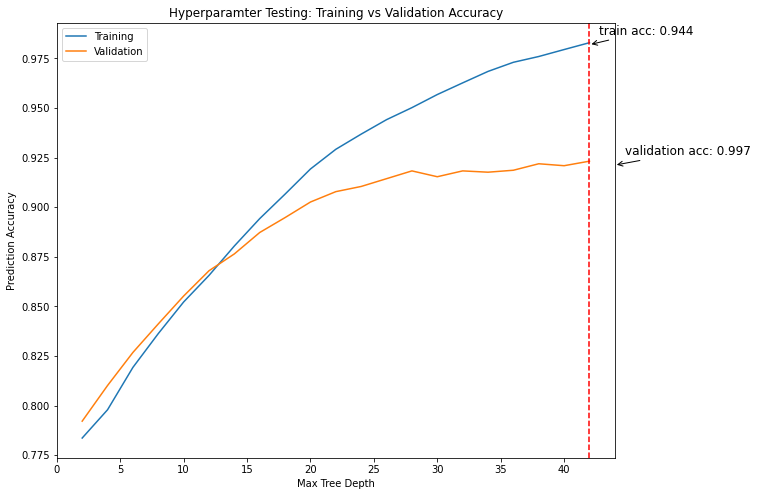

In [739]:
plt.figure(figsize=(10, 8))

x_ticks = list(range(2, 43, 2))
plt.plot(x_ticks, train_accuracy_list);
plt.plot(x_ticks, val_accuracy_list);

# Annotate the training error and validation error 
plt.axvline(x=(pos + 1)*2, color='r', linestyle='--')
plt.annotate('validation acc: 0.997',
            xy=((pos + 2)*2, val_accuracy_list[pos] - .002),
            xycoords='data',
            fontsize=12,
            xytext=(10, 10),
            textcoords='offset points',
            arrowprops=dict(arrowstyle="->", color='black',
                            connectionstyle="arc3"));
plt.annotate('train acc: 0.944',
            xy=((pos + 1)*2, train_accuracy_list[pos]-.001),
            xycoords='data',
            fontsize=12,
            xytext=(10, 10),
            textcoords='offset points',
            arrowprops=dict(arrowstyle="->", color='black',
                            connectionstyle="arc3"));
plt.title("Hyperparamter Testing: Training vs Validation Accuracy");
plt.ylabel('Prediction Accuracy');
plt.xlabel('Max Tree Depth');
plt.legend(['Training', 'Validation']);

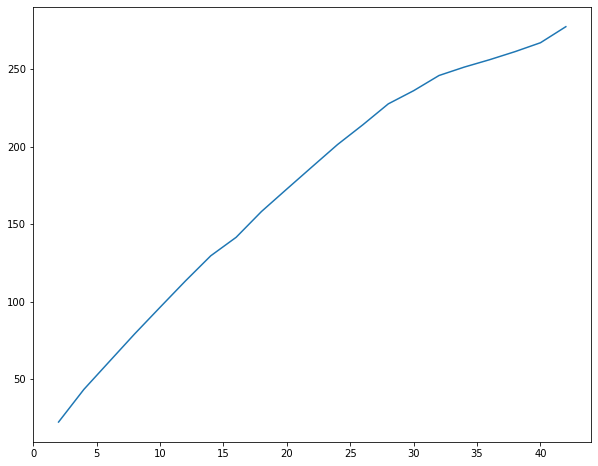

In [748]:
plt.figure(figsize=(10, 8))

x_ticks = list(range(2, 43, 2))
plt.plot(x_ticks, fit_time);

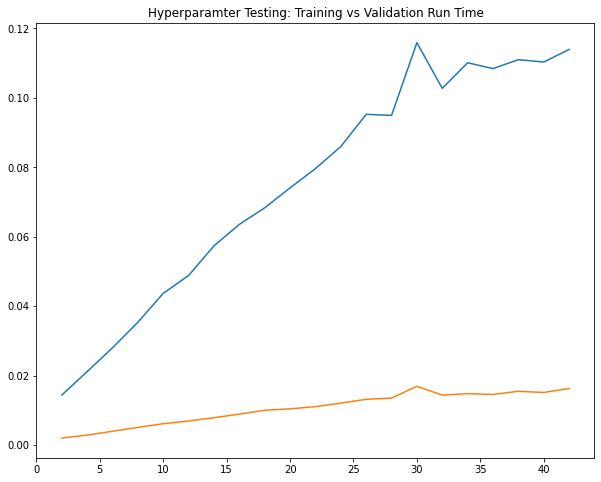

In [743]:
plt.figure(figsize=(10, 8))

x_ticks = list(range(2, 43, 2))
#plt.plot(x_ticks, fit_time);
plt.plot(x_ticks, train_pred_time);
plt.plot(x_ticks, val_pred_time);

# #Annotate the training error and validation error 
# plt.axvline(x=(pos + 1)*2, color='r', linestyle='--')
# plt.annotate('validation acc: 0.997',
#             xy=((pos + 2)*2, val_accuracy_list[pos] - .002),
#             xycoords='data',
#             fontsize=12,
#             xytext=(10, 10),
#             textcoords='offset points',
#             arrowprops=dict(arrowstyle="->", color='black',
#                             connectionstyle="arc3"));
# plt.annotate('train acc: 0.944',
#             xy=((pos + 1)*2, train_accuracy_list[pos]-.001),
#             xycoords='data',
#             fontsize=12,
#             xytext=(10, 10),
#             textcoords='offset points',
#             arrowprops=dict(arrowstyle="->", color='black',
#                             connectionstyle="arc3"));
plt.title("Hyperparamter Testing: Training vs Validation Run Time");
# plt.ylabel('Prediction Accuracy');
# plt.xlabel('Max Tree Depth');
# plt.legend(['Training', 'Validation']);
plt.show();

In [744]:
# Let't train a new model with the max tree depth of 28
tree2 = DecisionTreeClassifier(max_depth=42)
tree.fit(X_train_np, train_target_np)

KeyboardInterrupt: 

In [ ]:
## Accuracy for train set
train_pred = tree.predict(X_train_np)
total = len(train_pred)
correct = 0

for i in range(0, total):
    if train_pred[i] == train_target_np[i]:
        correct += 1

print(f"Accuracy = {correct/total}")

In [ ]:
## Accuracy for val set
pred2 = tree.predict(X_val_np)

total = len(pred2)
correct = 0

for i in range(0, total):
    if pred2[i] == val_target_np[i]:
        correct += 1

print(f"Accuracy = {correct/total}")

In [ ]:
## Accuracy for test set
pred3 = tree.predict(X_test_np)

total = len(pred3)
correct = 0

for i in range(0, total):
    if pred3[i] == test_target_np[i]:
        correct += 1

print(f"Accuracy = {correct/total}")